In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

ModuleNotFoundError: No module named 'dataprep'

In [ ]:
# Import Dataset
df = pd.read_excel('Airlines+Data.xlsx')
print('Shape of the data',df.shape)
df.head(10)

## Alias    Description
+ B        business day frequency
+ C        custom business day frequency
+ D        calendar day frequency
+ W        weekly frequency
+ M        month end frequency
+ SM       semi-month end frequency (15th and end of month)
+ BM       business month end frequency
+ CBM      custom business month end frequency
+ MS       month start frequency
+ SMS      semi-month start frequency (1st and 15th)
+ BMS      business month start frequency
+ CBMS     custom business month start frequency
+ Q        quarter end frequency
+ BQ       business quarter end frequency
+ QS       quarter start frequency
+ BQS      business quarter start frequency
+ A, Y     year end frequency
+ BA, BY   business year end frequency
+ AS, YS   year start frequency
+ BAS, BYS business year start frequency
+ BH       business hour frequency
+ H        hourly frequency
+ T, min   minutely frequency
+ S        secondly frequency
+ L, ms    milliseconds
+ U, us    microseconds
+ N        nanoseconds

## 3 Data Exploration

In [ ]:
df.isnull().any()

In [ ]:
df.isnull().sum()

In [ ]:
df.Passengers.plot(figsize=(12,4))

- We have no missing data so all the entries are valid for use.

- Now we can check the column names to get a better understanding of what features we will be basing our regression on.

In [ ]:
df.shape

In [ ]:
#Checking the data types
df.dtypes

In [ ]:
#Unique values for every feature
df.nunique()

In [ ]:
df.info()

In [ ]:
df[df.duplicated()].shape

In [ ]:
df[df.duplicated()]

In [ ]:
df.describe()

### Feature Engineering

#### Renaming the Month column into Date

In [ ]:
df.rename({'Month':'Date'},axis=1, inplace=True)

#### Making the Date as DateTime index for the Dataframe

In [ ]:
df1 = df.copy()
df1.set_index('Date',inplace=True)
df1.index.year

In [ ]:
df1.head()

#### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [ ]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

### Data Visualization

In [ ]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

#### Line plot

In [ ]:
df1['Passengers'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

##### Observation:^ 
1. We can see that there is an increasing Trend. So, Trend is not constant.
2. Variance is also not constant.

Hence the time serise is not stationary.

#### Yearly Passenger Analysis

In [ ]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Passengers",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

#### Box Plot of Each Year by Monthly Intervals

In [ ]:
# Boxplot for ever
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=df)

#### Histogram and Density Plots

In [ ]:
df.Passengers.hist(figsize=(12,6))
plt.show()

In [ ]:
# create a density plot
df.Passengers.plot(kind='kde', figsize=(12,6))
plt.show()

#### Lag plot

In [ ]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

### Moving Average

In [ ]:
plt.figure(figsize=(16,6))
df.Passengers.plot(label="org")
for i in range(4,13,4):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [ ]:
plt.figure(figsize=(16,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

In [ ]:
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

### Time series decomposition plot 

In [ ]:
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

### ACF plots and PACF plots

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

In [ ]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

In [ ]:
visual = df1.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual.head(10)

In [ ]:
visual.year.unique()

In [ ]:
# data 
df_1995 = visual[visual['year']==1995][['month','Passengers']]
df_1995 = df_1995.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1995'})
df_1996 = visual[visual['year']==1996][['month','Passengers']]
df_1996 = df_1996.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1996'})
df_1997 = visual[visual['year']==1997][['month','Passengers']]
df_1997 = df_1997.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1997'})
df_1998 = visual[visual['year']==1998][['month','Passengers']]
df_1998 = df_1998.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1998'})
df_1999 = visual[visual['year']==1999][['month','Passengers']]
df_1999 = df_1999.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1999'})
df_2000 = visual[visual['year']==2000][['month','Passengers']]
df_2000 = df_2000.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2000'})
df_2001 = visual[visual['year']==2001][['month','Passengers']]
df_2001 = df_2001.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2001'})
df_2002 = visual[visual['year']==2002][['month','Passengers']]
df_2002 = df_2002.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2002'})



df_year = df_1995.merge(df_1996,on='month').merge(df_1997,on='month').merge(df_1998,on='month').merge(df_1999,on='month')\
.merge(df_2000,on='month').merge(df_2001,on='month').merge(df_2002,on='month')

# top levels
top_labels = ['1995', '1996', '1997', '1998', '1999','2000','2001','2002']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)']

# X axis value 
df_year = df_year[['1995', '1996', '1997', '1998', '1999','2000','2001','2002']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1995['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1995['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

        
fig.update_layout(title='Avg Passengers for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

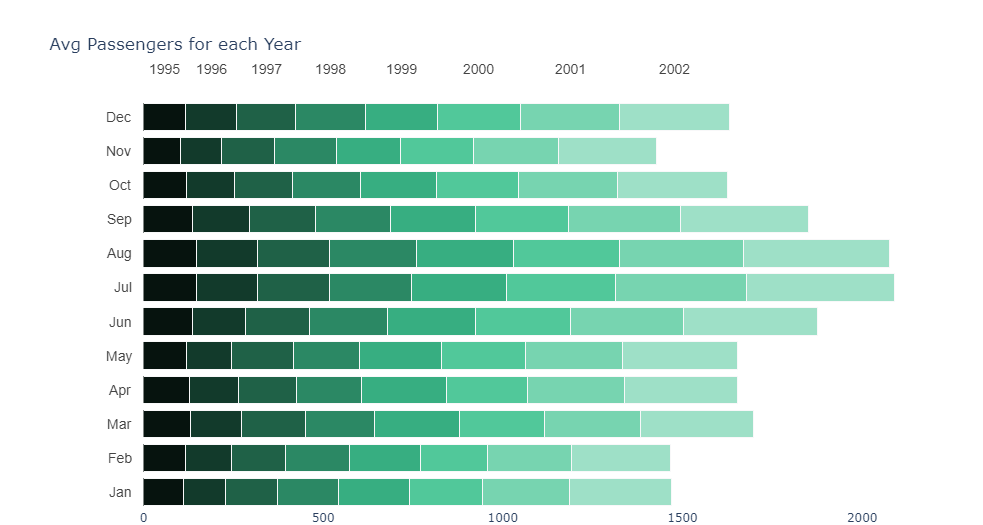

In [ ]:
# data
import calendar
df_m_sa = visual.groupby('month').agg({"Passengers" : "mean"}).reset_index()
df_m_sa['Passengers'] = round(df_m_sa['Passengers'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Passengers'].astype(str) 

df_w_sa = visual.groupby('week').agg({"Passengers" : "mean"}).reset_index() 
df_q_sa = visual.groupby('quarter').agg({"Passengers" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Passengers Analysis", "Quarter wise Avg Passengers Analysis", 
                                    "Week wise Avg Passengers Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['Passengers'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Passengers'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Passengers'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Passengers Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

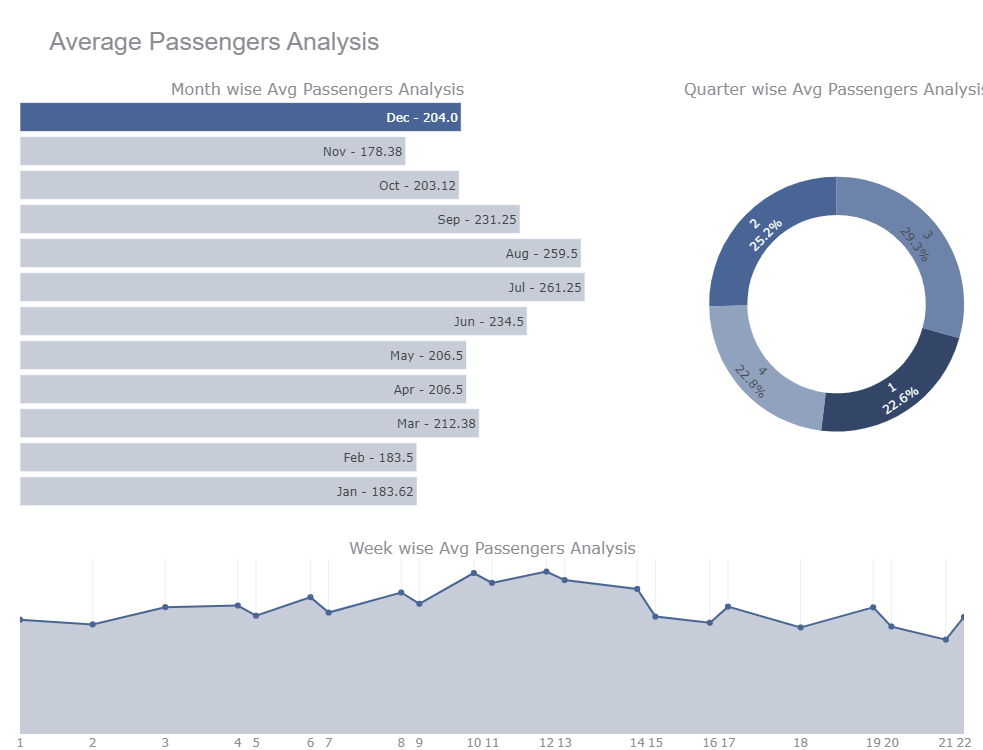

In [ ]:
# data
df_dw_sa = visual.groupby('day_of_week').agg({"Passengers" : "mean"}).reset_index()
df_dw_sa.Passengers = round(df_dw_sa.Passengers, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Passengers', title='Avg Passengers vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='Passengers',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

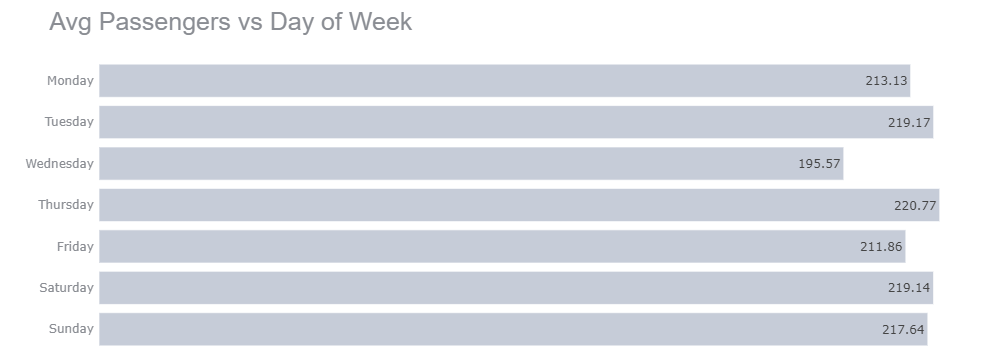

In [ ]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

#### Observation:-
1. ***Observed*** - Actual data
2. ***Trend*** - Increasing or decreasing trend.
3. ***Seasonal*** - 
    - Varies from +50 to -50 with the mean 0. 
    - Each cycle represents each year trend.
    - The value in the Y-axis has to be `added` to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is +50 and the trend value is 100. Hence, teh actual value(passengers number) will (seasonal+Trend) value = 50+100 = 150.
4. ***Residual*** - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)

#### Multiplicative Seasonal Decomposition

In [ ]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

#### Observation:-

***Seasonal*** - 
1. Varies from 0.8 to 1.2 
2. The value in the Y-axis has to be `multiplied` to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is `1.2` and the trend value is `100`. Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.


### Splitting Train and Test Data
#### Leaving Test Data with 2 Years of Time Series

In [ ]:
size = 72
train_data = df1[:size]
test_data = df1[size:]

In [ ]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

We are going to forecat for the last two years. 2001 and 2002.

Last 24 records contain From 2001 to 2002 data.

In [ ]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

### Evaluation Metric MAPE

In [ ]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Exponential Methods
### Simple Exponential Method

#### Using Forecast Attribute

In [ ]:
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#### Observation
1. No seasonality captures.
2. Most recent observation gets higher weightages than the older ones for forecasting.

---
### Holt method (Double Exponential) 

##### Captures both Level and Trend .

In [ ]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Passengers))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

##### Captures Level, Trend and Seasonality.

In [ ]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Passengers))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

#### Observation
1. It captures the trend, which we can see that the forecasted values are lower level than the test level.
2. It also captures the seasonality.
3. The peak of the forecasted value is lower than the actual.

### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [ ]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Passengers))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [ ]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Passengers))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Passengers)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

#### Observation
1. It captures the trend, which we can see that the forecasted values are higher level than the test level.
2. It also captures the seasonality.
3. The peak of the forecasted value is higher than the actual.

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [ ]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Passengers))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Passengers)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [ ]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

### Visualizing Models Performance

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

In [ ]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

## ARIMA

### Test of Stationarity

##### As we have yearly data the window size for moving average is equal to 12

In [ ]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
sales= pd.DataFrame()
sales['Passengers'] = df1[['Passengers']]
test_stationarity(sales)

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
adf_test(sales)

### Feature Scaling (Transformations)

#### Square Root Transform

In [ ]:
square_root= pd.DataFrame()
square_root = df1[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

In [ ]:
test_stationarity(square_root)

In [ ]:
adf_test(square_root)

#### Log Transform

In [ ]:
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

In [ ]:
test_stationarity(log)

In [ ]:
adf_test(log)

##### Hence, the Time series data is Non-Stationary

### Converting Non-Stationary Time Series into Stationary

In [ ]:
differencing = df1 - df1.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

In [ ]:
test_stationarity(differencing)

In [ ]:
adf_test(differencing)

In [ ]:
seasonal_differencing = df1 - df1.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [ ]:
test_stationarity(seasonal_differencing)

In [ ]:
adf_test(seasonal_differencing)

#### Transformation

In [ ]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

In [ ]:
test_stationarity(log_diff)

In [ ]:
adf_test(log_diff)

#### Box Cox Transformation

In [ ]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(df1['Passengers'], lmbda=0), df1.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df1, label='original')
axis[1].set_title('Original')
plt.show()

#### Observation
1. We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.
2. But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do `Differencing` for making the mean constant.

In [ ]:
test_stationarity(data_boxcox)

In [ ]:
adf_test(data_boxcox)

#### Differencing of the Box-Cox Transformation

In [ ]:
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
#data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation. 
2. It is a horizontal trend.
3. The mean became constant. The mean is zero.
4. Also, the variance is almost constant.

Lets test the Stationarity again.

In [ ]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [ ]:
adf_test(data_boxcox_diff)

##### Finally, Our Series is now stationary for AR Forecasting

#### ARIMA Hyperparameter Tuning

In [ ]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(data_boxcox_diff.Passengers, p_values, d_values, q_values)

#### Building The Time Series Forecasting with Optimal Value using ARIMA

In [ ]:
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

##### Inverse transformation of the Box-Cox Differencing 

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we have done moderately well.
2. No Seasonality captured. Only Trend has been captured

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [ ]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

#### MAPE (Mean Absolute Percent Error)

In [ ]:
mape_arima = round(np.mean(np.abs((test_data.Passengers - y_hat_ar['ar_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_arima

#### Observation
1. We can see that AR model has done reasonably good job but not better than Holt's method.
2. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [ ]:
model_residual = model_fit.resid
model_residual.mean()

#### Residuals must be stationary

In [ ]:
adf_test(model_residual)

#### No autocorrelation between residuals

In [ ]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

In [ ]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)
ARIMA with Seasonal component added.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [ ]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

#### Inverse Transformation of the Differencing Box-Cox Transformation

In [ ]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

##### We can see that we are able to capture the trend and seasonality both.

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [ ]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

#### MAPE (Mean Absolute Percent Error)

In [ ]:
mape_sarima = round(np.mean(np.abs((test_data.Passengers - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_sarima

#### Observation:
1. SARIMA method has done reasonably well as it captures seasonality.
2. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. |

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [ ]:
model_residual = model_fit.resid
model_residual.mean()

#### Residuals must be stationary

In [ ]:
adf_test(model_residual)

#### No autocorrelation between residuals

In [ ]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

In [ ]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Creating model with differente Transformation Technique

In [ ]:
#Compareing the results 

Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

#### Observation:
+ **The Sarima Model did very well as compared to other Models but Holts-Winter Method did slightly better** 
**Note:Sarima with Hyperparameter tuning may get better results**
+ **Even in methods such as Triple Exponential Smoothing (Holts-Winters Method) taking Seasonality and Trend as Multiplicative gave the best restult in this case**

### Data Pre-processing for Model Driven Techniques

#### Creating Dummy Variables of the Categorical Feature Month of Date Time feature 

In [ ]:
cocacola = df1.copy()
cocacola.reset_index(inplace=True)
cocacola['t'] = np.arange(1,len(cocacola)+1)
cocacola['t_squared'] = np.square(cocacola.t)
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(cocacola['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([cocacola,months],axis=1)
cocacola['log_passengers'] = np.log(cocacola['Passengers'])
cocacola

#### Splitting data into Train and Test 

In [ ]:
train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [ ]:
train_data

In [ ]:
test_data

### Building Ordinary Square Model (Linear Model)

In [ ]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

In [ ]:
linear_model.summary()

In [ ]:
#Exponential

Exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

In [ ]:
Exp.summary()

In [ ]:
#Quadratic 

Quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

In [ ]:
Quad.summary()

In [ ]:
#Additive seasonality 

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

In [ ]:
add_sea.summary()

In [ ]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

In [ ]:
add_sea_Quad.summary()

In [ ]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

In [ ]:
Mul_sea.summary()

In [ ]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

In [ ]:
Mul_Add_sea.summary()

In [ ]:
np.exp(pred_Mult_add_sea)

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(np.exp(pred_Mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
#Compare the results 

data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [ ]:
e = table_rmse.append(table_evaluation)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [ ]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()

#### Conclusion:
## <p style="color:black;font-size:18;">Ordinary Least Sqaured with Multiplicative Additive Seasonality:</p><p style="color:black;font-size:14px;">The best model we have got so far with the lowest RMSE and lowest MAPE.</p>    